# Notes
This is the notebook for training and running the Multi-Task model:
 - Two consective images and two metadata from the same grind location are stored.
 - The images are sent to a YOLOv8 backbone, and the metadata sent to a MLP.
 - The image feature vectors are subtracted, and the feature difference vector and the two metadata vectors are concatenated together.
 - Finally, this fused and (hopefully) temporally informed vector is sent to a classification head that predictsw good/bad.

I have all of the models get training data from a directory structure. This design decision was influenced by YOLO itself - before I used the classification variant I was labeling the training data in label studio and making bounding boxes, and I had to use this directory structure. It is now no critical to the design of the model, but it works well.

## SET MODEL SETTINGS

In [1]:
# Set to either 'grind_trial' or 'polish_trial'
train_type = 'polish_trial'
# The trial number (1-5)
trial_num = 5

# Set the training data pickle file name string
data_batch_file_str = f'train_batch_{train_type}_df.pkl'

# Set the custom identifier for the output model metrics files
# Choose a unique one.
variant_name = f'{trial_num}{train_type}'

# Sometimes it's useful to run this notebook without training
start_training = True

# Batch size and number of workers:
batch_size = 16
num_workers = 4
# Jitter params
jitter_params = dict(brightness=0.1, contrast=0.1, saturation=0.0, hue=0.0)

## Obtain Project Directory

In [2]:
from pathlib import Path
notebook_dir = Path.cwd()
parent_dir = notebook_dir.parent.parent
print(parent_dir)

c:\Users\jackson129\OneDrive - LLNL\APEX_Cornell_Analysis


## * Important! * - Check Model Seed

In [3]:
# Print Model Seed. It should match what is in seed_main.
# If it does not, restart this notebook to refresh __pycache__
from seed import SEED
print(SEED)

2003


## Load in the Training Data from the Analysis Notebook

In [4]:
import pickle

with open(parent_dir / 'orchestrator' / data_batch_file_str, 'rb') as f:
    df = pickle.load(f)

display(df)

,image_id,label,grit_time,grit_step,image
0,420,0,60,1.00,<PIL.PngImagePlugin.PngImageFile image mode=L ...
9,421,0,60,1.00,<PIL.PngImagePlugin.PngImageFile image mode=L ...
18,422,0,60,1.00,<PIL.PngImagePlugin.PngImageFile image mode=L ...
27,423,0,60,1.00,<PIL.PngImagePlugin.PngImageFile image mode=L ...
36,424,0,60,1.00,<PIL.PngImagePlugin.PngImageFile image mode=L ...
...,...,...,...,...,...
152,772,1,900,0.08,<PIL.PngImagePlugin.PngImageFile image mode=L ...
161,773,1,900,0.08,<PIL.PngImagePlugin.PngImageFile image mode=L ...
170,774,1,900,0.08,<PIL.PngImagePlugin.PngImageFile image mode=L ...
179,775,1,900,0.08,<PIL.PngImagePlugin.PngImageFile image mode=L ...


## Create the Directory Structure, Text Files (for bounding boxes), and All Other Files Needed For YOLO

In [5]:
import os
import pandas as pd
from sklearn.model_selection import train_test_split
import shutil
from seed import SEED
import torch
import random
import numpy as np

torch.manual_seed(SEED)
random.seed(SEED)
np.random.seed(SEED)

def clear_folder(folder_path):
    if os.path.exists(folder_path):
        for filename in os.listdir(folder_path):
            file_path = os.path.join(folder_path, filename)
            try:
                if os.path.isfile(file_path) or os.path.islink(file_path):
                    os.unlink(file_path)
                elif os.path.isdir(file_path):
                    shutil.rmtree(file_path)
            except Exception as e:
                print(f'Failed to delete {file_path}. Reason: {e}')

# 1. Add trial and location columns
df['trial'] = df['image_id'] // 21
df['location'] = df['image_id'] % 21

# Save the unique grit steps (useful for later testing)
unique_grit_steps = sorted(df['grit_step'].unique())


# 2. Sort by location, then trial
df = df.sort_values(['location', 'trial'])
all_data_df = df.copy()

# Difference between trials number for pairing.
# For polishing it is 2 (because images were taken at 100X and 200X)
# For grinding it is 1
trial_difference = 2 if train_type == 'polish_trial' else 1

# 3. Generate all consecutive pairs for each location
all_pairs = []
for loc in df['location'].unique():
    loc_df = df[df['location'] == loc].sort_values('trial')
    trials = loc_df['trial'].tolist()
    trial_to_row = {row['trial']: row for _, row in loc_df.iterrows()}
    for i in range(len(trials) - 1):
        t1, t2 = trials[i], trials[i + 1]
        # Only consecutive trials
        if t2 - t1 == trial_difference:
            row1 = trial_to_row[t1]
            row2 = trial_to_row[t2]
            all_pairs.append({
                'img_id1': row1['image_id'],
                'img_id2': row2['image_id'],
                'label1': row1['label'],
                'label2': row2['label'],
                'location': loc,
                'trial1': row1['trial'],
                'trial2': row2['trial'],
                'image1': row1['image'],
                'image2': row2['image'],
                'grit_time1': row1['grit_time'],
                'grit_time2': row2['grit_time'],
                'grit_step1': row1['grit_step'],
                'grit_step2': row2['grit_step'],
            })

# IDEA - PERHAPS MAKE VAL TAKE LOCATIONS DIVISIBLE BY 5
# 4. Split pairs into train/val
all_pairs_df = pd.DataFrame(all_pairs)
# 1. Assign images to splits
# Example: Split by location
unique_locations = df['location'].unique()
train_locs, val_locs = train_test_split(unique_locations, test_size=0.3, random_state=SEED)
train_loc_set = set(train_locs)
val_loc_set = set(val_locs)

train_pairs_df = all_pairs_df[all_pairs_df['location'].isin(train_loc_set)].copy()
val_pairs_df = all_pairs_df[all_pairs_df['location'].isin(val_loc_set)].copy()

pairs_df = pd.concat([train_pairs_df, val_pairs_df], ignore_index=True)

# 5. Prepare image folders
base = 'dataset'
imgs_pairs = os.path.join(base, 'images')

# Get all unique class labels
all_labels = pd.concat([pairs_df['label1'], pairs_df['label2']])
class_names = sorted(all_labels.unique())

for subset, pairs in [('train', train_pairs_df), ('val', val_pairs_df)]:
    for cls in class_names:
        folder = os.path.join(imgs_pairs, subset, str(cls))
        os.makedirs(folder, exist_ok=True)
        clear_folder(folder)

def save_pair_subset_cls(pairs_df, subset):
    for _, row in pairs_df.iterrows():
        img_id1 = row['img_id1']
        img_id2 = row['img_id2']
        image1 = row['image1']
        image2 = row['image2']
        label1 = row['label1']
        label2 = row['label2']

        img_path1 = os.path.join(imgs_pairs, subset, str(label1), f"{img_id1}.jpg")
        img_path2 = os.path.join(imgs_pairs, subset, str(label2), f"{img_id2}.jpg")
        image1.save(img_path1, format='JPEG', quality=95)
        image2.save(img_path2, format='JPEG', quality=95)

save_pair_subset_cls(train_pairs_df, 'train')
save_pair_subset_cls(val_pairs_df, 'val')

# 6. Save metadata
metadata_cols = [
    'img_id1', 'img_id2', 'label1', 'label2', 'grit_time1', 
    'grit_time2', 'grit_step1', 'grit_step2'
]

pair_md = pairs_df[metadata_cols]
pair_md.to_csv(os.path.join(base, 'metadata.csv'), index=False)
train_md = train_pairs_df[metadata_cols]
train_md.to_csv(os.path.join(base, 'train_metadata.csv'), index=False)
val_md = val_pairs_df[metadata_cols]
val_md.to_csv(os.path.join(base, 'val_metadata.csv'), index=False)


## VALIDATE THAT NO IMAGES ARE SHARED! ##
import os

def get_all_image_paths(root_dir):
    image_paths = set()
    for dirpath, _, filenames in os.walk(root_dir):
        for filename in filenames:
            if filename.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp', '.gif')):
                # Use relative paths from the root_dir for comparison
                rel_path = os.path.relpath(os.path.join(dirpath, filename), root_dir)
                image_paths.add(rel_path)
    return image_paths

train_dir = 'dataset/images/train'
val_dir = 'dataset/images/val'

train_images = get_all_image_paths(train_dir)
val_images = get_all_image_paths(val_dir)

# Check for overlap by filename (relative to class subfolder)
overlap = train_images & val_images

if overlap:
    print("Overlap detected! Images are present in both train and val sets:")
    for img in overlap:
        print(img)
else:
    print("No overlap detected between train and val image sets.")

No overlap detected between train and val image sets.


## Load DataSets and Create DataLoaders

Train samples: 448
  Val samples: 56
Sample shapes: torch.Size([3, 640, 640]) torch.Size([2]) torch.Size([3, 640, 640]) torch.Size([2]) tensor(0)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.5849519..0.91171503].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.56474..0.77023137].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.6051638..1.3765898].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.6051638..1.3765898].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.56474..0.91171503].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.46368..0.77023137].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.443468..

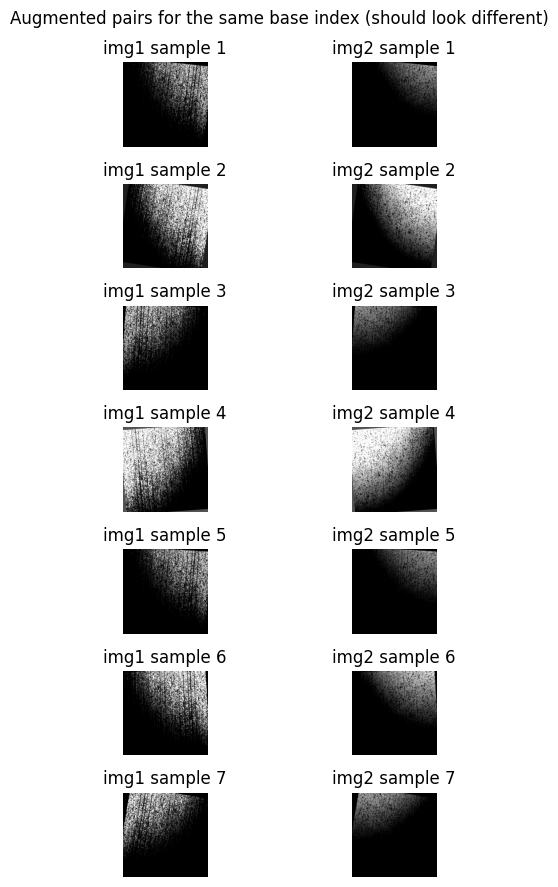

In [6]:
import pandas as pd
from torch.utils.data import DataLoader
from dataset_yolo_pairs import *

torch.use_deterministic_algorithms(True)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
torch.manual_seed(SEED)

# Correct paths for your file structure
train_pairs_csv = "dataset/train_metadata.csv"
val_pairs_csv   = "dataset/val_metadata.csv"

# Instantiate transforms with correct image size for cls network
train_pairwise_transform = PairwiseTransform(image_size=(640, 640), train=True, jitter_params=jitter_params)
val_pairwise_transform   = PairwiseTransform(image_size=(640, 640), train=False)


import numpy as np

meta_cols1 = ['grit_time1', 'grit_step1']
meta_cols2 = ['grit_time2', 'grit_step2']
train_meta_df = pd.read_csv("dataset/metadata.csv")
meta_mean1 = train_meta_df[meta_cols1].mean().values
meta_std1  = train_meta_df[meta_cols1].std().values
meta_mean2 = train_meta_df[meta_cols2].mean().values
meta_std2  = train_meta_df[meta_cols2].std().values


# Updated image directories
train_ds = PairwiseGrindingDataset(
    images_dir   = "dataset/images/train",
    pairs_csv    = train_pairs_csv,
    transform    = train_pairwise_transform,
    preload_images = True,
    oversample_factor=4,
    meta1_mean=meta_mean1,
    meta1_std=meta_std1,
    meta2_mean=meta_mean2,
    meta2_std=meta_std2
)

val_ds = PairwiseGrindingDataset(
    images_dir   = "dataset/images/val",
    pairs_csv    = val_pairs_csv,
    transform    = val_pairwise_transform,
    preload_images = True,
    oversample_factor=1,
    meta1_mean=meta_mean1,
    meta1_std=meta_std1,
    meta2_mean=meta_mean2,
    meta2_std=meta_std2
)





train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True,  num_workers=num_workers, pin_memory=True)
val_loader   = DataLoader(val_ds,   batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=True)

print(f"Train samples: {len(train_ds)}")
print(f"  Val samples: {len(val_ds)}")

# Example: Get a sample and print shapes
img1, meta1, img2, meta2, lbl = train_ds[0]
print("Sample shapes:", img1.size(), meta1.shape, img2.size(), meta2.shape, lbl)





import matplotlib.pyplot as plt

# Pick a base index (e.g., 0)
base_idx = 0
n_samples = 7

fig, axes = plt.subplots(n_samples, 2, figsize=(6, 9))
fig.suptitle("Augmented pairs for the same base index (should look different)")

for i in range(n_samples):
    idx = base_idx + i * len(train_ds.df)
    img1, meta1, img2, meta2, label = train_ds[idx]
    # Convert tensors back to images for display
    img1_np = img1.permute(1, 2, 0).numpy()
    img2_np = img2.permute(1, 2, 0).numpy()
    axes[i, 0].imshow(img1_np)
    axes[i, 0].set_title(f"img1 sample {i+1}")
    axes[i, 1].imshow(img2_np)
    axes[i, 1].set_title(f"img2 sample {i+1}")
    for ax in axes[i]:
        ax.axis('off')

plt.tight_layout()
plt.show()

## Training Loop

In [7]:
from torch.utils.data import DataLoader
import torch.optim as optim
import torch.nn as nn
import torch
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, roc_curve
from tqdm import tqdm
from model import*

def get_default_device():
    if torch.backends.mps.is_available() and torch.backends.mps.is_built():
        return torch.device("mps")
    elif torch.cuda.is_available():
        return torch.device("cuda")
    else:
        return torch.device("cpu")

device = get_default_device()
print(f"Using device: {device}")

num_epochs = 100
learn_rate = 0.0001

train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

model = PairwiseGrindingYOLOClassifier(
    yolo_weights='yolov8n-cls.pt',
    metadata_dim=2,
    num_classes=2
).to(device)

optimizer = optim.Adam(model.parameters(), lr=learn_rate, weight_decay=1e-2)
criterion = nn.CrossEntropyLoss()

# --- Compute total steps for OneCycleLR ---
train_dataset_size = len(train_loader.dataset)
batch_size = train_loader.batch_size
steps_per_epoch = len(train_loader)
total_steps = num_epochs * steps_per_epoch

"""
# --- OneCycleLR Scheduler ---
scheduler = optim.lr_scheduler.OneCycleLR(
    optimizer,
    max_lr=learn_rate,                # peak learning rate
    steps_per_epoch=steps_per_epoch,
    epochs=num_epochs,
    pct_start=0.05,                   # 5% warmup, then anneal
    anneal_strategy='cos',            # cosine annealing
    div_factor=25.0,                  # initial_lr = max_lr/div_factor
    final_div_factor=1e4              # min_lr = initial_lr/final_div_factor
)
"""

import pickle
import numpy as np

# ... (your imports and setup code above)

# Containers for all metrics per epoch
metrics_per_epoch = []

if start_training:
    print(f'Training Started with learning rate {learn_rate}...')
    for epoch in range(1, num_epochs + 1):
        # ——— train ———
        model.train()
        running_loss, correct, total = 0, 0, 0
        all_train_preds = []
        all_train_labels = []
        all_train_probs = []
        train_loader_tqdm = tqdm(train_loader, desc=f"Epoch {epoch}/{num_epochs} [Train]", leave=False)
        for img1, img2, meta1, meta2, labels in train_loader_tqdm:
            img1, img2 = img1.to(device), img2.to(device)
            meta1, meta2 = meta1.to(device), meta2.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            logits = model(img1, img2, meta1, meta2)
            loss = criterion(logits, labels)
            loss.backward()
            optimizer.step()
            #scheduler.step()

            running_loss += loss.item() * labels.size(0)
            preds = logits.argmax(dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
            all_train_preds.extend(preds.cpu().numpy())
            all_train_labels.extend(labels.cpu().numpy())
            probs = torch.softmax(logits, dim=1)[:, 1]
            all_train_probs.extend(probs.detach().cpu().numpy().tolist())

            train_loader_tqdm.set_postfix(loss=loss.item())

        train_loss = running_loss / total
        train_acc = correct / total
        train_losses.append(train_loss)
        train_accuracies.append(train_acc)

        # Train metrics
        train_precision = precision_score(all_train_labels, all_train_preds, zero_division=0)
        train_recall = recall_score(all_train_labels, all_train_preds, zero_division=0)
        train_f1 = f1_score(all_train_labels, all_train_preds, zero_division=0)
        if len(np.unique(all_train_labels)) == 2:
            train_roc_auc = roc_auc_score(all_train_labels, all_train_probs)
        else:
            train_roc_auc = float('nan')

        print(f"Epoch {epoch} | Train loss {train_loss:.4f} | Train acc {train_acc:.4f} | "
            f"Prec {train_precision:.4f} | Rec {train_recall:.4f} | F1 {train_f1:.4f} | ROC AUC {train_roc_auc:.4f}")

        # ——— validate ———
        model.eval()
        val_running_loss, val_correct, val_total = 0, 0, 0
        all_val_preds = []
        all_val_labels = []
        all_val_probs = []
        val_loader_tqdm = tqdm(val_loader, desc=f"Epoch {epoch}/{num_epochs} [Val]", leave=False)
        with torch.no_grad():
            for img1, img2, meta1, meta2, labels in val_loader_tqdm:
                img1, img2 = img1.to(device), img2.to(device)
                meta1, meta2 = meta1.to(device), meta2.to(device)
                labels = labels.to(device)
                logits = model(img1, img2, meta1, meta2)
                loss = criterion(logits, labels)
                preds = logits.argmax(dim=1)
                val_running_loss += loss.item() * labels.size(0)
                val_correct += (preds == labels).sum().item()
                val_total += labels.size(0)
                all_val_preds.extend(preds.cpu().numpy())
                all_val_labels.extend(labels.cpu().numpy())
                probs = torch.softmax(logits, dim=1)[:, 1]
                all_val_probs.extend(probs.detach().cpu().numpy().tolist())

                val_loader_tqdm.set_postfix(loss=loss.item())

        val_loss = val_running_loss / val_total
        val_acc = val_correct / val_total
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)

        val_precision = precision_score(all_val_labels, all_val_preds, zero_division=0)
        val_recall = recall_score(all_val_labels, all_val_preds, zero_division=0)
        val_f1 = f1_score(all_val_labels, all_val_preds, zero_division=0)
        if len(np.unique(all_val_labels)) == 2:
            val_roc_auc = roc_auc_score(all_val_labels, all_val_probs)
        else:
            val_roc_auc = float('nan')
            print("Warning: Only one class present in y_true; ROC AUC score is undefined for this epoch.")

        print(f"           | Val loss  {val_loss:.4f} | Val acc   {val_acc:.4f} | "
            f"Prec {val_precision:.4f} | Rec {val_recall:.4f} | F1 {val_f1:.4f} | ROC AUC {val_roc_auc:.4f}")

        # --- Store all metrics for this epoch ---
        metrics_per_epoch.append({
            "epoch": epoch,
            "train_loss": train_loss,
            "train_acc": train_acc,
            "train_precision": train_precision,
            "train_recall": train_recall,
            "train_f1": train_f1,
            "train_roc_auc": train_roc_auc,
            "val_loss": val_loss,
            "val_acc": val_acc,
            "val_precision": val_precision,
            "val_recall": val_recall,
            "val_f1": val_f1,
            "val_roc_auc": val_roc_auc,
            "val_true_labels": all_val_labels,
            "val_pred_labels": all_val_preds,
            "val_probs": all_val_probs
        })

    # --- Save all epoch metrics to pickle ---
    with open(f"runs/run{variant_name}.pkl", "wb") as f:
        pickle.dump(metrics_per_epoch, f)
    print(f"Saved all epoch metrics to out{variant_name}.pkl")

    torch.save(model.state_dict(), f'saved_models/model_{variant_name}.pth')

Setup: Will run dynamic‐forward on modules [0:8]  Setup(Detect is at 9)
Total parameters: 2,764,986
Trainable parameters: 45,698

Detailed parameter breakdown:
  img_backbone.layers.0.conv: 432 parameters
  img_backbone.layers.0.bn: 32 parameters
  img_backbone.layers.1.conv: 4,608 parameters
  img_backbone.layers.1.bn: 64 parameters
  img_backbone.layers.2.cv1.conv: 1,024 parameters
  img_backbone.layers.2.cv1.bn: 64 parameters
  img_backbone.layers.2.cv2.conv: 1,536 parameters
  img_backbone.layers.2.cv2.bn: 64 parameters
  img_backbone.layers.2.m.0.cv1.conv: 2,304 parameters
  img_backbone.layers.2.m.0.cv1.bn: 32 parameters
  img_backbone.layers.2.m.0.cv2.conv: 2,304 parameters
  img_backbone.layers.2.m.0.cv2.bn: 32 parameters
  img_backbone.layers.3.conv: 18,432 parameters
  img_backbone.layers.3.bn: 128 parameters
  img_backbone.layers.4.cv1.conv: 4,096 parameters
  img_backbone.layers.4.cv1.bn: 128 parameters
  img_backbone.layers.4.cv2.conv: 8,192 parameters
  img_backbone.layer

Epoch 1 | Train loss 0.6897 | Train acc 0.5246 | Prec 0.4983 | Rec 0.6792 | F1 0.5749 | ROC AUC 0.5708


           | Val loss  0.6844 | Val acc   0.5357 | Prec 0.5217 | Rec 0.8571 | F1 0.6486 | ROC AUC 0.7513


Epoch 2 | Train loss 0.6766 | Train acc 0.6295 | Prec 0.5816 | Rec 0.7736 | F1 0.6640 | ROC AUC 0.6975


           | Val loss  0.6722 | Val acc   0.6786 | Prec 0.6190 | Rec 0.9286 | F1 0.7429 | ROC AUC 0.8584


Epoch 3 | Train loss 0.6665 | Train acc 0.6629 | Prec 0.6169 | Rec 0.7594 | F1 0.6808 | ROC AUC 0.7432


           | Val loss  0.6581 | Val acc   0.7857 | Prec 0.7222 | Rec 0.9286 | F1 0.8125 | ROC AUC 0.8916


Epoch 4 | Train loss 0.6521 | Train acc 0.7188 | Prec 0.6720 | Rec 0.7925 | F1 0.7273 | ROC AUC 0.8176


           | Val loss  0.6466 | Val acc   0.7679 | Prec 0.7027 | Rec 0.9286 | F1 0.8000 | ROC AUC 0.9018


Epoch 5 | Train loss 0.6376 | Train acc 0.7366 | Prec 0.7043 | Rec 0.7642 | F1 0.7330 | ROC AUC 0.8322


           | Val loss  0.6304 | Val acc   0.8214 | Prec 0.7500 | Rec 0.9643 | F1 0.8438 | ROC AUC 0.9031


Epoch 6 | Train loss 0.6239 | Train acc 0.7879 | Prec 0.7489 | Rec 0.8302 | F1 0.7875 | ROC AUC 0.8698


           | Val loss  0.6140 | Val acc   0.8036 | Prec 0.7429 | Rec 0.9286 | F1 0.8254 | ROC AUC 0.9094


Epoch 7 | Train loss 0.6062 | Train acc 0.8147 | Prec 0.7945 | Rec 0.8208 | F1 0.8074 | ROC AUC 0.8871


           | Val loss  0.5950 | Val acc   0.8036 | Prec 0.7297 | Rec 0.9643 | F1 0.8308 | ROC AUC 0.9133


Epoch 8 | Train loss 0.5790 | Train acc 0.8147 | Prec 0.7817 | Rec 0.8443 | F1 0.8118 | ROC AUC 0.9075


           | Val loss  0.5685 | Val acc   0.8036 | Prec 0.7297 | Rec 0.9643 | F1 0.8308 | ROC AUC 0.9145


Epoch 9 | Train loss 0.5517 | Train acc 0.8438 | Prec 0.8227 | Rec 0.8538 | F1 0.8380 | ROC AUC 0.9195


           | Val loss  0.5450 | Val acc   0.7857 | Prec 0.7222 | Rec 0.9286 | F1 0.8125 | ROC AUC 0.9209


Epoch 10 | Train loss 0.5203 | Train acc 0.8504 | Prec 0.8139 | Rec 0.8868 | F1 0.8488 | ROC AUC 0.9254


           | Val loss  0.5191 | Val acc   0.8036 | Prec 0.7297 | Rec 0.9643 | F1 0.8308 | ROC AUC 0.9222


Epoch 11 | Train loss 0.4858 | Train acc 0.8772 | Prec 0.8552 | Rec 0.8915 | F1 0.8730 | ROC AUC 0.9439


           | Val loss  0.4980 | Val acc   0.7857 | Prec 0.7222 | Rec 0.9286 | F1 0.8125 | ROC AUC 0.9196


Epoch 12 | Train loss 0.4549 | Train acc 0.8705 | Prec 0.8407 | Rec 0.8962 | F1 0.8676 | ROC AUC 0.9398


           | Val loss  0.4693 | Val acc   0.7857 | Prec 0.7222 | Rec 0.9286 | F1 0.8125 | ROC AUC 0.9209


Epoch 13 | Train loss 0.4082 | Train acc 0.8929 | Prec 0.8727 | Rec 0.9057 | F1 0.8889 | ROC AUC 0.9587


           | Val loss  0.4554 | Val acc   0.7857 | Prec 0.7222 | Rec 0.9286 | F1 0.8125 | ROC AUC 0.9196


Epoch 14 | Train loss 0.4000 | Train acc 0.8884 | Prec 0.8785 | Rec 0.8868 | F1 0.8826 | ROC AUC 0.9489


           | Val loss  0.4465 | Val acc   0.7857 | Prec 0.7222 | Rec 0.9286 | F1 0.8125 | ROC AUC 0.9184


Epoch 15 | Train loss 0.3678 | Train acc 0.8996 | Prec 0.8848 | Rec 0.9057 | F1 0.8951 | ROC AUC 0.9509


           | Val loss  0.4280 | Val acc   0.7857 | Prec 0.7222 | Rec 0.9286 | F1 0.8125 | ROC AUC 0.9209


Epoch 16 | Train loss 0.3456 | Train acc 0.9040 | Prec 0.8894 | Rec 0.9104 | F1 0.8998 | ROC AUC 0.9578


           | Val loss  0.4225 | Val acc   0.7857 | Prec 0.7222 | Rec 0.9286 | F1 0.8125 | ROC AUC 0.9209


Epoch 17 | Train loss 0.3032 | Train acc 0.9062 | Prec 0.8935 | Rec 0.9104 | F1 0.9019 | ROC AUC 0.9705


           | Val loss  0.4075 | Val acc   0.7857 | Prec 0.7222 | Rec 0.9286 | F1 0.8125 | ROC AUC 0.9222


Epoch 18 | Train loss 0.3176 | Train acc 0.8862 | Prec 0.8610 | Rec 0.9057 | F1 0.8828 | ROC AUC 0.9518


           | Val loss  0.4106 | Val acc   0.7679 | Prec 0.7027 | Rec 0.9286 | F1 0.8000 | ROC AUC 0.9260


Epoch 19 | Train loss 0.3135 | Train acc 0.8862 | Prec 0.8779 | Rec 0.8821 | F1 0.8800 | ROC AUC 0.9547


           | Val loss  0.3959 | Val acc   0.7679 | Prec 0.7027 | Rec 0.9286 | F1 0.8000 | ROC AUC 0.9311


Epoch 20 | Train loss 0.3063 | Train acc 0.8973 | Prec 0.9029 | Rec 0.8774 | F1 0.8900 | ROC AUC 0.9548


           | Val loss  0.3917 | Val acc   0.7857 | Prec 0.7222 | Rec 0.9286 | F1 0.8125 | ROC AUC 0.9324


Epoch 21 | Train loss 0.2862 | Train acc 0.8951 | Prec 0.8767 | Rec 0.9057 | F1 0.8910 | ROC AUC 0.9615


           | Val loss  0.3900 | Val acc   0.7857 | Prec 0.7222 | Rec 0.9286 | F1 0.8125 | ROC AUC 0.9349


Epoch 22 | Train loss 0.2705 | Train acc 0.9018 | Prec 0.8889 | Rec 0.9057 | F1 0.8972 | ROC AUC 0.9659


           | Val loss  0.3967 | Val acc   0.7857 | Prec 0.7222 | Rec 0.9286 | F1 0.8125 | ROC AUC 0.9362


Epoch 23 | Train loss 0.2658 | Train acc 0.9219 | Prec 0.9116 | Rec 0.9245 | F1 0.9180 | ROC AUC 0.9671


           | Val loss  0.3878 | Val acc   0.7857 | Prec 0.7222 | Rec 0.9286 | F1 0.8125 | ROC AUC 0.9388


Epoch 24 | Train loss 0.2253 | Train acc 0.9263 | Prec 0.9124 | Rec 0.9340 | F1 0.9231 | ROC AUC 0.9810


           | Val loss  0.3795 | Val acc   0.7857 | Prec 0.7222 | Rec 0.9286 | F1 0.8125 | ROC AUC 0.9413


Epoch 25 | Train loss 0.2236 | Train acc 0.9353 | Prec 0.9336 | Rec 0.9292 | F1 0.9314 | ROC AUC 0.9794


           | Val loss  0.3915 | Val acc   0.7857 | Prec 0.7222 | Rec 0.9286 | F1 0.8125 | ROC AUC 0.9362


Epoch 26 | Train loss 0.2197 | Train acc 0.9241 | Prec 0.9320 | Rec 0.9057 | F1 0.9187 | ROC AUC 0.9788


           | Val loss  0.3863 | Val acc   0.7857 | Prec 0.7222 | Rec 0.9286 | F1 0.8125 | ROC AUC 0.9413


Epoch 27 | Train loss 0.1993 | Train acc 0.9420 | Prec 0.9471 | Rec 0.9292 | F1 0.9381 | ROC AUC 0.9856


           | Val loss  0.3965 | Val acc   0.8036 | Prec 0.7429 | Rec 0.9286 | F1 0.8254 | ROC AUC 0.9413


Epoch 28 | Train loss 0.1981 | Train acc 0.9308 | Prec 0.9372 | Rec 0.9151 | F1 0.9260 | ROC AUC 0.9837


           | Val loss  0.4119 | Val acc   0.7857 | Prec 0.7222 | Rec 0.9286 | F1 0.8125 | ROC AUC 0.9401


Epoch 29 | Train loss 0.2060 | Train acc 0.9241 | Prec 0.9045 | Rec 0.9387 | F1 0.9213 | ROC AUC 0.9788


           | Val loss  0.3852 | Val acc   0.8036 | Prec 0.7429 | Rec 0.9286 | F1 0.8254 | ROC AUC 0.9439


Epoch 30 | Train loss 0.2113 | Train acc 0.9241 | Prec 0.9083 | Rec 0.9340 | F1 0.9209 | ROC AUC 0.9791


           | Val loss  0.3883 | Val acc   0.8036 | Prec 0.7429 | Rec 0.9286 | F1 0.8254 | ROC AUC 0.9452


Epoch 31 | Train loss 0.1690 | Train acc 0.9621 | Prec 0.9621 | Rec 0.9575 | F1 0.9598 | ROC AUC 0.9838


           | Val loss  0.3947 | Val acc   0.8036 | Prec 0.7429 | Rec 0.9286 | F1 0.8254 | ROC AUC 0.9413


Epoch 32 | Train loss 0.1937 | Train acc 0.9219 | Prec 0.9194 | Rec 0.9151 | F1 0.9173 | ROC AUC 0.9802


           | Val loss  0.3875 | Val acc   0.8036 | Prec 0.7429 | Rec 0.9286 | F1 0.8254 | ROC AUC 0.9477


Epoch 33 | Train loss 0.1806 | Train acc 0.9330 | Prec 0.9333 | Rec 0.9245 | F1 0.9289 | ROC AUC 0.9848


           | Val loss  0.3780 | Val acc   0.8036 | Prec 0.7429 | Rec 0.9286 | F1 0.8254 | ROC AUC 0.9464


Epoch 34 | Train loss 0.1729 | Train acc 0.9531 | Prec 0.9569 | Rec 0.9434 | F1 0.9501 | ROC AUC 0.9841


           | Val loss  0.3871 | Val acc   0.8214 | Prec 0.7647 | Rec 0.9286 | F1 0.8387 | ROC AUC 0.9464


Epoch 35 | Train loss 0.1921 | Train acc 0.9263 | Prec 0.9282 | Rec 0.9151 | F1 0.9216 | ROC AUC 0.9797


           | Val loss  0.3746 | Val acc   0.8036 | Prec 0.7429 | Rec 0.9286 | F1 0.8254 | ROC AUC 0.9528


Epoch 36 | Train loss 0.1808 | Train acc 0.9487 | Prec 0.9522 | Rec 0.9387 | F1 0.9454 | ROC AUC 0.9811


           | Val loss  0.3779 | Val acc   0.8036 | Prec 0.7429 | Rec 0.9286 | F1 0.8254 | ROC AUC 0.9477


Epoch 37 | Train loss 0.1693 | Train acc 0.9464 | Prec 0.9608 | Rec 0.9245 | F1 0.9423 | ROC AUC 0.9865


           | Val loss  0.3897 | Val acc   0.8036 | Prec 0.7429 | Rec 0.9286 | F1 0.8254 | ROC AUC 0.9477


Epoch 38 | Train loss 0.1919 | Train acc 0.9241 | Prec 0.9120 | Rec 0.9292 | F1 0.9206 | ROC AUC 0.9784


           | Val loss  0.3617 | Val acc   0.8214 | Prec 0.7647 | Rec 0.9286 | F1 0.8387 | ROC AUC 0.9490


Epoch 39 | Train loss 0.1774 | Train acc 0.9375 | Prec 0.9340 | Rec 0.9340 | F1 0.9340 | ROC AUC 0.9850


           | Val loss  0.3580 | Val acc   0.8393 | Prec 0.7879 | Rec 0.9286 | F1 0.8525 | ROC AUC 0.9528


Epoch 40 | Train loss 0.1812 | Train acc 0.9420 | Prec 0.9387 | Rec 0.9387 | F1 0.9387 | ROC AUC 0.9804


           | Val loss  0.3586 | Val acc   0.8393 | Prec 0.7879 | Rec 0.9286 | F1 0.8525 | ROC AUC 0.9490


Epoch 41 | Train loss 0.1457 | Train acc 0.9554 | Prec 0.9486 | Rec 0.9575 | F1 0.9531 | ROC AUC 0.9900


           | Val loss  0.3865 | Val acc   0.8393 | Prec 0.7879 | Rec 0.9286 | F1 0.8525 | ROC AUC 0.9452


Epoch 42 | Train loss 0.1459 | Train acc 0.9487 | Prec 0.9437 | Rec 0.9481 | F1 0.9459 | ROC AUC 0.9891


           | Val loss  0.3655 | Val acc   0.8393 | Prec 0.7879 | Rec 0.9286 | F1 0.8525 | ROC AUC 0.9452


Epoch 43 | Train loss 0.1600 | Train acc 0.9353 | Prec 0.9256 | Rec 0.9387 | F1 0.9321 | ROC AUC 0.9879


           | Val loss  0.3576 | Val acc   0.8393 | Prec 0.7879 | Rec 0.9286 | F1 0.8525 | ROC AUC 0.9477


Epoch 44 | Train loss 0.1730 | Train acc 0.9308 | Prec 0.9209 | Rec 0.9340 | F1 0.9274 | ROC AUC 0.9843


           | Val loss  0.3528 | Val acc   0.8393 | Prec 0.7879 | Rec 0.9286 | F1 0.8525 | ROC AUC 0.9464


Epoch 45 | Train loss 0.1485 | Train acc 0.9487 | Prec 0.9522 | Rec 0.9387 | F1 0.9454 | ROC AUC 0.9902


           | Val loss  0.3538 | Val acc   0.8393 | Prec 0.7879 | Rec 0.9286 | F1 0.8525 | ROC AUC 0.9477


Epoch 46 | Train loss 0.1637 | Train acc 0.9397 | Prec 0.9384 | Rec 0.9340 | F1 0.9362 | ROC AUC 0.9844


           | Val loss  0.3461 | Val acc   0.8393 | Prec 0.7879 | Rec 0.9286 | F1 0.8525 | ROC AUC 0.9515


Epoch 47 | Train loss 0.1507 | Train acc 0.9397 | Prec 0.9512 | Rec 0.9198 | F1 0.9353 | ROC AUC 0.9893


           | Val loss  0.3480 | Val acc   0.8571 | Prec 0.8125 | Rec 0.9286 | F1 0.8667 | ROC AUC 0.9503


Epoch 48 | Train loss 0.1441 | Train acc 0.9531 | Prec 0.9526 | Rec 0.9481 | F1 0.9504 | ROC AUC 0.9905


           | Val loss  0.3569 | Val acc   0.8214 | Prec 0.7647 | Rec 0.9286 | F1 0.8387 | ROC AUC 0.9528


Epoch 49 | Train loss 0.1529 | Train acc 0.9420 | Prec 0.9559 | Rec 0.9198 | F1 0.9375 | ROC AUC 0.9874


           | Val loss  0.3419 | Val acc   0.8393 | Prec 0.7879 | Rec 0.9286 | F1 0.8525 | ROC AUC 0.9541


Epoch 50 | Train loss 0.1644 | Train acc 0.9464 | Prec 0.9519 | Rec 0.9340 | F1 0.9429 | ROC AUC 0.9841


           | Val loss  0.3645 | Val acc   0.8393 | Prec 0.7879 | Rec 0.9286 | F1 0.8525 | ROC AUC 0.9503


Epoch 51 | Train loss 0.1332 | Train acc 0.9531 | Prec 0.9484 | Rec 0.9528 | F1 0.9506 | ROC AUC 0.9928


           | Val loss  0.3550 | Val acc   0.8393 | Prec 0.7879 | Rec 0.9286 | F1 0.8525 | ROC AUC 0.9515


Epoch 52 | Train loss 0.1536 | Train acc 0.9487 | Prec 0.9479 | Rec 0.9434 | F1 0.9456 | ROC AUC 0.9874


           | Val loss  0.3571 | Val acc   0.8393 | Prec 0.7879 | Rec 0.9286 | F1 0.8525 | ROC AUC 0.9528


Epoch 53 | Train loss 0.1446 | Train acc 0.9576 | Prec 0.9617 | Rec 0.9481 | F1 0.9549 | ROC AUC 0.9901


           | Val loss  0.3335 | Val acc   0.8393 | Prec 0.7879 | Rec 0.9286 | F1 0.8525 | ROC AUC 0.9541


Epoch 54 | Train loss 0.1742 | Train acc 0.9442 | Prec 0.9517 | Rec 0.9292 | F1 0.9403 | ROC AUC 0.9813


           | Val loss  0.3350 | Val acc   0.8393 | Prec 0.7879 | Rec 0.9286 | F1 0.8525 | ROC AUC 0.9528


Epoch 55 | Train loss 0.1224 | Train acc 0.9509 | Prec 0.9481 | Rec 0.9481 | F1 0.9481 | ROC AUC 0.9941


           | Val loss  0.3387 | Val acc   0.8393 | Prec 0.7879 | Rec 0.9286 | F1 0.8525 | ROC AUC 0.9541


Epoch 56 | Train loss 0.1563 | Train acc 0.9487 | Prec 0.9522 | Rec 0.9387 | F1 0.9454 | ROC AUC 0.9856


           | Val loss  0.3437 | Val acc   0.8393 | Prec 0.7879 | Rec 0.9286 | F1 0.8525 | ROC AUC 0.9503


Epoch 57 | Train loss 0.1493 | Train acc 0.9509 | Prec 0.9439 | Rec 0.9528 | F1 0.9484 | ROC AUC 0.9876


           | Val loss  0.3201 | Val acc   0.8393 | Prec 0.7879 | Rec 0.9286 | F1 0.8525 | ROC AUC 0.9528


Epoch 58 | Train loss 0.1334 | Train acc 0.9509 | Prec 0.9612 | Rec 0.9340 | F1 0.9474 | ROC AUC 0.9926


           | Val loss  0.3195 | Val acc   0.8393 | Prec 0.7879 | Rec 0.9286 | F1 0.8525 | ROC AUC 0.9541


Epoch 59 | Train loss 0.1467 | Train acc 0.9554 | Prec 0.9615 | Rec 0.9434 | F1 0.9524 | ROC AUC 0.9889


           | Val loss  0.3524 | Val acc   0.8393 | Prec 0.7879 | Rec 0.9286 | F1 0.8525 | ROC AUC 0.9554


Epoch 60 | Train loss 0.1052 | Train acc 0.9777 | Prec 0.9764 | Rec 0.9764 | F1 0.9764 | ROC AUC 0.9963


           | Val loss  0.3392 | Val acc   0.8393 | Prec 0.7879 | Rec 0.9286 | F1 0.8525 | ROC AUC 0.9554


Epoch 61 | Train loss 0.1221 | Train acc 0.9643 | Prec 0.9712 | Rec 0.9528 | F1 0.9619 | ROC AUC 0.9917


           | Val loss  0.3329 | Val acc   0.8393 | Prec 0.7879 | Rec 0.9286 | F1 0.8525 | ROC AUC 0.9566


Epoch 62 | Train loss 0.1126 | Train acc 0.9710 | Prec 0.9585 | Rec 0.9811 | F1 0.9697 | ROC AUC 0.9958


           | Val loss  0.3314 | Val acc   0.8571 | Prec 0.8125 | Rec 0.9286 | F1 0.8667 | ROC AUC 0.9528


Epoch 63 | Train loss 0.1384 | Train acc 0.9509 | Prec 0.9567 | Rec 0.9387 | F1 0.9476 | ROC AUC 0.9902


           | Val loss  0.3271 | Val acc   0.8571 | Prec 0.8125 | Rec 0.9286 | F1 0.8667 | ROC AUC 0.9515


Epoch 64 | Train loss 0.1127 | Train acc 0.9665 | Prec 0.9758 | Rec 0.9528 | F1 0.9642 | ROC AUC 0.9946


           | Val loss  0.3343 | Val acc   0.8393 | Prec 0.7879 | Rec 0.9286 | F1 0.8525 | ROC AUC 0.9515


Epoch 65 | Train loss 0.1259 | Train acc 0.9554 | Prec 0.9571 | Rec 0.9481 | F1 0.9526 | ROC AUC 0.9914


           | Val loss  0.3413 | Val acc   0.8393 | Prec 0.7879 | Rec 0.9286 | F1 0.8525 | ROC AUC 0.9515


Epoch 66 | Train loss 0.1357 | Train acc 0.9531 | Prec 0.9614 | Rec 0.9387 | F1 0.9499 | ROC AUC 0.9895


           | Val loss  0.3381 | Val acc   0.8571 | Prec 0.8125 | Rec 0.9286 | F1 0.8667 | ROC AUC 0.9490


Epoch 67 | Train loss 0.1366 | Train acc 0.9509 | Prec 0.9481 | Rec 0.9481 | F1 0.9481 | ROC AUC 0.9898


           | Val loss  0.3306 | Val acc   0.8393 | Prec 0.7879 | Rec 0.9286 | F1 0.8525 | ROC AUC 0.9503


Epoch 68 | Train loss 0.1146 | Train acc 0.9554 | Prec 0.9571 | Rec 0.9481 | F1 0.9526 | ROC AUC 0.9940


           | Val loss  0.3412 | Val acc   0.8393 | Prec 0.7879 | Rec 0.9286 | F1 0.8525 | ROC AUC 0.9528


Epoch 69 | Train loss 0.1226 | Train acc 0.9621 | Prec 0.9577 | Rec 0.9623 | F1 0.9600 | ROC AUC 0.9935


           | Val loss  0.3282 | Val acc   0.8393 | Prec 0.7879 | Rec 0.9286 | F1 0.8525 | ROC AUC 0.9515


Epoch 70 | Train loss 0.1153 | Train acc 0.9688 | Prec 0.9714 | Rec 0.9623 | F1 0.9668 | ROC AUC 0.9946


           | Val loss  0.3120 | Val acc   0.8571 | Prec 0.8125 | Rec 0.9286 | F1 0.8667 | ROC AUC 0.9541


Epoch 71 | Train loss 0.1185 | Train acc 0.9576 | Prec 0.9531 | Rec 0.9575 | F1 0.9553 | ROC AUC 0.9944


           | Val loss  0.3379 | Val acc   0.8571 | Prec 0.8125 | Rec 0.9286 | F1 0.8667 | ROC AUC 0.9490


Epoch 72 | Train loss 0.1264 | Train acc 0.9509 | Prec 0.9524 | Rec 0.9434 | F1 0.9479 | ROC AUC 0.9917


           | Val loss  0.3164 | Val acc   0.8571 | Prec 0.8125 | Rec 0.9286 | F1 0.8667 | ROC AUC 0.9515


Epoch 73 | Train loss 0.1237 | Train acc 0.9554 | Prec 0.9486 | Rec 0.9575 | F1 0.9531 | ROC AUC 0.9935


           | Val loss  0.2951 | Val acc   0.8750 | Prec 0.8387 | Rec 0.9286 | F1 0.8814 | ROC AUC 0.9579


Epoch 74 | Train loss 0.1175 | Train acc 0.9598 | Prec 0.9709 | Rec 0.9434 | F1 0.9569 | ROC AUC 0.9937


           | Val loss  0.2972 | Val acc   0.8750 | Prec 0.8387 | Rec 0.9286 | F1 0.8814 | ROC AUC 0.9566


Epoch 75 | Train loss 0.1055 | Train acc 0.9531 | Prec 0.9614 | Rec 0.9387 | F1 0.9499 | ROC AUC 0.9960


           | Val loss  0.3212 | Val acc   0.8393 | Prec 0.7879 | Rec 0.9286 | F1 0.8525 | ROC AUC 0.9579


Epoch 76 | Train loss 0.1099 | Train acc 0.9643 | Prec 0.9579 | Rec 0.9670 | F1 0.9624 | ROC AUC 0.9952


           | Val loss  0.2945 | Val acc   0.8393 | Prec 0.7879 | Rec 0.9286 | F1 0.8525 | ROC AUC 0.9554


Epoch 77 | Train loss 0.1180 | Train acc 0.9509 | Prec 0.9439 | Rec 0.9528 | F1 0.9484 | ROC AUC 0.9940


           | Val loss  0.3244 | Val acc   0.8571 | Prec 0.8125 | Rec 0.9286 | F1 0.8667 | ROC AUC 0.9566


Epoch 78 | Train loss 0.1265 | Train acc 0.9554 | Prec 0.9706 | Rec 0.9340 | F1 0.9519 | ROC AUC 0.9906


           | Val loss  0.3230 | Val acc   0.8571 | Prec 0.8125 | Rec 0.9286 | F1 0.8667 | ROC AUC 0.9554


Epoch 79 | Train loss 0.1105 | Train acc 0.9665 | Prec 0.9581 | Rec 0.9717 | F1 0.9649 | ROC AUC 0.9952


           | Val loss  0.3191 | Val acc   0.8393 | Prec 0.7879 | Rec 0.9286 | F1 0.8525 | ROC AUC 0.9528


Epoch 80 | Train loss 0.1004 | Train acc 0.9576 | Prec 0.9531 | Rec 0.9575 | F1 0.9553 | ROC AUC 0.9961


           | Val loss  0.3289 | Val acc   0.8393 | Prec 0.8065 | Rec 0.8929 | F1 0.8475 | ROC AUC 0.9503


Epoch 81 | Train loss 0.1028 | Train acc 0.9621 | Prec 0.9665 | Rec 0.9528 | F1 0.9596 | ROC AUC 0.9953


           | Val loss  0.3186 | Val acc   0.8571 | Prec 0.8333 | Rec 0.8929 | F1 0.8621 | ROC AUC 0.9541


Epoch 82 | Train loss 0.1358 | Train acc 0.9442 | Prec 0.9474 | Rec 0.9340 | F1 0.9406 | ROC AUC 0.9904


           | Val loss  0.3358 | Val acc   0.8571 | Prec 0.8125 | Rec 0.9286 | F1 0.8667 | ROC AUC 0.9528


Epoch 83 | Train loss 0.1053 | Train acc 0.9621 | Prec 0.9665 | Rec 0.9528 | F1 0.9596 | ROC AUC 0.9964


           | Val loss  0.3300 | Val acc   0.8393 | Prec 0.8065 | Rec 0.8929 | F1 0.8475 | ROC AUC 0.9490


Epoch 84 | Train loss 0.1018 | Train acc 0.9710 | Prec 0.9761 | Rec 0.9623 | F1 0.9691 | ROC AUC 0.9953


           | Val loss  0.3425 | Val acc   0.8393 | Prec 0.7879 | Rec 0.9286 | F1 0.8525 | ROC AUC 0.9541


Epoch 85 | Train loss 0.1077 | Train acc 0.9643 | Prec 0.9667 | Rec 0.9575 | F1 0.9621 | ROC AUC 0.9939


           | Val loss  0.3363 | Val acc   0.8393 | Prec 0.7879 | Rec 0.9286 | F1 0.8525 | ROC AUC 0.9579


Epoch 86 | Train loss 0.0944 | Train acc 0.9777 | Prec 0.9903 | Rec 0.9623 | F1 0.9761 | ROC AUC 0.9970


           | Val loss  0.3387 | Val acc   0.8571 | Prec 0.8125 | Rec 0.9286 | F1 0.8667 | ROC AUC 0.9515


Epoch 87 | Train loss 0.0932 | Train acc 0.9710 | Prec 0.9716 | Rec 0.9670 | F1 0.9693 | ROC AUC 0.9979


           | Val loss  0.3210 | Val acc   0.8750 | Prec 0.8387 | Rec 0.9286 | F1 0.8814 | ROC AUC 0.9554


Epoch 88 | Train loss 0.0922 | Train acc 0.9665 | Prec 0.9758 | Rec 0.9528 | F1 0.9642 | ROC AUC 0.9966


           | Val loss  0.3387 | Val acc   0.8571 | Prec 0.8125 | Rec 0.9286 | F1 0.8667 | ROC AUC 0.9515


Epoch 89 | Train loss 0.1076 | Train acc 0.9643 | Prec 0.9757 | Rec 0.9481 | F1 0.9617 | ROC AUC 0.9944


           | Val loss  0.3359 | Val acc   0.8750 | Prec 0.8387 | Rec 0.9286 | F1 0.8814 | ROC AUC 0.9554


Epoch 90 | Train loss 0.1159 | Train acc 0.9643 | Prec 0.9623 | Rec 0.9623 | F1 0.9623 | ROC AUC 0.9928


           | Val loss  0.3397 | Val acc   0.8571 | Prec 0.8125 | Rec 0.9286 | F1 0.8667 | ROC AUC 0.9528


Epoch 91 | Train loss 0.1000 | Train acc 0.9732 | Prec 0.9717 | Rec 0.9717 | F1 0.9717 | ROC AUC 0.9950


           | Val loss  0.3205 | Val acc   0.8750 | Prec 0.8387 | Rec 0.9286 | F1 0.8814 | ROC AUC 0.9566


Epoch 92 | Train loss 0.1139 | Train acc 0.9531 | Prec 0.9659 | Rec 0.9340 | F1 0.9496 | ROC AUC 0.9939


           | Val loss  0.3164 | Val acc   0.8393 | Prec 0.7879 | Rec 0.9286 | F1 0.8525 | ROC AUC 0.9554


Epoch 93 | Train loss 0.1028 | Train acc 0.9710 | Prec 0.9807 | Rec 0.9575 | F1 0.9690 | ROC AUC 0.9954


           | Val loss  0.3333 | Val acc   0.8750 | Prec 0.8387 | Rec 0.9286 | F1 0.8814 | ROC AUC 0.9541


Epoch 94 | Train loss 0.1207 | Train acc 0.9442 | Prec 0.9431 | Rec 0.9387 | F1 0.9409 | ROC AUC 0.9930


           | Val loss  0.2983 | Val acc   0.8929 | Prec 0.8667 | Rec 0.9286 | F1 0.8966 | ROC AUC 0.9566


Epoch 95 | Train loss 0.0937 | Train acc 0.9688 | Prec 0.9626 | Rec 0.9717 | F1 0.9671 | ROC AUC 0.9964


           | Val loss  0.3164 | Val acc   0.8571 | Prec 0.8125 | Rec 0.9286 | F1 0.8667 | ROC AUC 0.9541


Epoch 96 | Train loss 0.0978 | Train acc 0.9710 | Prec 0.9854 | Rec 0.9528 | F1 0.9688 | ROC AUC 0.9951


           | Val loss  0.3333 | Val acc   0.8571 | Prec 0.8125 | Rec 0.9286 | F1 0.8667 | ROC AUC 0.9528


Epoch 97 | Train loss 0.0967 | Train acc 0.9732 | Prec 0.9762 | Rec 0.9670 | F1 0.9716 | ROC AUC 0.9958


           | Val loss  0.3276 | Val acc   0.8393 | Prec 0.7879 | Rec 0.9286 | F1 0.8525 | ROC AUC 0.9592


Epoch 98 | Train loss 0.1218 | Train acc 0.9442 | Prec 0.9390 | Rec 0.9434 | F1 0.9412 | ROC AUC 0.9926


           | Val loss  0.3195 | Val acc   0.8929 | Prec 0.8667 | Rec 0.9286 | F1 0.8966 | ROC AUC 0.9566


Epoch 99 | Train loss 0.1105 | Train acc 0.9643 | Prec 0.9623 | Rec 0.9623 | F1 0.9623 | ROC AUC 0.9940


           | Val loss  0.3191 | Val acc   0.8750 | Prec 0.8387 | Rec 0.9286 | F1 0.8814 | ROC AUC 0.9541


Epoch 100 | Train loss 0.1305 | Train acc 0.9509 | Prec 0.9439 | Rec 0.9528 | F1 0.9484 | ROC AUC 0.9901


           | Val loss  0.3188 | Val acc   0.8750 | Prec 0.8387 | Rec 0.9286 | F1 0.8814 | ROC AUC 0.9579
Saved all epoch metrics to out5polish_trial.pkl


In [8]:
import torch
import time
import numpy as np

def measure_single_sample_inference_time(
    model, 
    sample, 
    device=None, 
    num_repeats=100, 
    input_unpack_fn=None
):
    """
    Measures average inference time for a single sample repeated num_repeats times.
    Args:
        model: PyTorch model (should be in eval mode)
        sample: A single batch/sample from the dataloader
        device: torch.device or None (default: use model's device)
        num_repeats: Number of times to repeat inference (default: 100)
        input_unpack_fn: Optional function to extract model inputs from sample
    Returns:
        total_time, avg_time_per_sample, std_dev, std_error
    """
    model.eval()
    if device is None:
        device = next(model.parameters()).device
    if input_unpack_fn is None:
        input_unpack_fn = lambda batch: batch[0] if isinstance(batch, (tuple, list)) else batch

    # Move sample to device
    if isinstance(sample, (tuple, list)):
        sample_on_device = [b.to(device) if torch.is_tensor(b) else b for b in sample]
    elif isinstance(sample, dict):
        sample_on_device = {k: (v.to(device) if torch.is_tensor(v) else v) for k, v in sample.items()}
    else:
        sample_on_device = sample.to(device) if torch.is_tensor(sample) else sample

    model_inputs = input_unpack_fn(sample_on_device)
    if not isinstance(model_inputs, (tuple, list)):
        model_inputs = (model_inputs,)

    # List to store individual inference times
    inference_times = []

    with torch.no_grad():
        # Warmup (especially important for GPU timing)
        for _ in range(5):
            _ = model(*model_inputs)
        if device.type == "cuda":
            torch.cuda.synchronize()

        # Measure individual inference times
        for _ in range(num_repeats):
            if device.type == "cuda":
                torch.cuda.synchronize()
            
            start_time = time.time()
            _ = model(*model_inputs)
            
            if device.type == "cuda":
                torch.cuda.synchronize()
            
            end_time = time.time()
            inference_times.append(end_time - start_time)

    # Calculate statistics
    total_time = sum(inference_times)
    avg_time_per_sample = total_time / num_repeats
    std_dev = np.std(inference_times, ddof=1)  # trying to measure sample from LARGER distribution
    std_error = std_dev / np.sqrt(num_repeats)

    print(f"Total inference time for {num_repeats} samples: {total_time:.6f} seconds")
    print(f"Average inference time per sample: {avg_time_per_sample:.8f} seconds")
    print(f"Standard deviation: {std_dev:.8f} seconds")
    print(f"Standard error: {std_error:.8f} seconds")
    
    return total_time, avg_time_per_sample, std_dev, std_error

## Example: measure inference time for your model and val_loader
def input_unpack(batch):
    img1, meta1, img2, meta2, _ = batch
    return img1, meta1, img2, meta2
    

model = PairwiseGrindingYOLOClassifier(
    yolo_weights='yolov8n-cls.pt',
    metadata_dim=2,
    num_classes=2
).to(device)

sample = next(iter(val_loader))

model.load_state_dict(torch.load(f'saved_models/model_{variant_name}.pth'))
total, avg, std_dev, std_error = measure_single_sample_inference_time(
    model,
    sample,
    device=device,
    num_repeats=100,
    input_unpack_fn=input_unpack
)

with open(f"other_metrics/inf_times_{variant_name}.pkl", "wb") as f:
    pickle.dump({
        'total': total, 
        'avg': avg, 
        'std_dev': std_dev, 
        'std_error': std_error
    }, f)

Setup: Will run dynamic‐forward on modules [0:8]  Setup(Detect is at 9)


Total inference time for 100 samples: 1.790026 seconds
Average inference time per sample: 0.01790026 seconds
Standard deviation: 0.00409383 seconds
Standard error: 0.00040938 seconds


## Overfit Test - Swap Max and min Grind Times

In [9]:
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np
from PIL import Image
import os
import pandas as pd
import torchvision.transforms as transforms
from seed import SEED

# Set seeds for reproducibility
torch.manual_seed(SEED)
np.random.seed(SEED)

# --- 1. Load validation pairs dataframe ---
base_dir = 'dataset'
val_md_path = os.path.join(base_dir, 'val_metadata.csv')
val_pairs_df = pd.read_csv(val_md_path)

# --- 2. Select all samples for lowest and highest grit_time for each grit_step ---
selected_rows = []

# Make sure grit_step values are preserved as floating point numbers
val_pairs_df['grit_step1'] = val_pairs_df['grit_step1'].astype(float)

for grit, group in val_pairs_df.groupby('grit_step1', dropna=False):
    min_time = group['grit_time1'].min()
    max_time = group['grit_time1'].max()
    # Select all rows where grind_time is min or max for this grit_step
    selected = group[(group['grit_time1'] == min_time) | (group['grit_time1'] == max_time)]
    selected_rows.append(selected)
    print(f"Grit step {grit}: {len(selected)} samples selected")
selected_df = pd.concat(selected_rows).reset_index(drop=True)

# --- 3. Custom Dataset for selected pairs ---
class SelectedPairwiseValDataset(Dataset):
    def __init__(self, df, images_dir, meta1_mean, meta1_std, meta2_mean, meta2_std, transform):
        self.df = df
        self.images_dir = images_dir
        self.meta1_mean = torch.tensor(meta1_mean, dtype=torch.float32)
        self.meta1_std = torch.tensor(meta1_std, dtype=torch.float32)
        self.meta2_mean = torch.tensor(meta2_mean, dtype=torch.float32)
        self.meta2_std = torch.tensor(meta2_std, dtype=torch.float32)
        self.transform = transform
        
        # Preload images
        self.image_cache = {}
        for _, row in self.df.iterrows():
            img_id1 = self._normalize_id(row['img_id1'])
            class1 = self._normalize_id(row['label1'])
            img_id2 = self._normalize_id(row['img_id2'])
            class2 = self._normalize_id(row['label2'])
            for img_id, class_label in [(img_id1, class1), (img_id2, class2)]:
                key = f"{class_label}/{img_id}"
                if key not in self.image_cache:
                    img_path = os.path.join(self.images_dir, class_label, f"{img_id}.jpg")
                    try:
                        img = Image.open(img_path).convert("RGB")
                        self.image_cache[key] = img
                    except Exception as e:
                        raise RuntimeError(f"Failed to load image: {img_path}\n{e}")
    
    def __len__(self):
        return len(self.df)
    
    def _normalize_id(self, raw):
        if isinstance(raw, (float, int)):
            return str(int(raw))
        else:
            return str(raw)
    
    def _get_image(self, img_id, class_label):
        img_id = self._normalize_id(img_id)
        class_label = self._normalize_id(class_label)
        key = f"{class_label}/{img_id}"
        return self.image_cache[key].copy()

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        
        img1 = self._get_image(row['img_id1'], row['label1'])
        img2 = self._get_image(row['img_id2'], row['label2'])
        
        if self.transform:
            img1, img2 = self.transform(img1, img2)
        
        meta1 = torch.tensor([row['grit_time1'], row['grit_step1']], dtype=torch.float32)
        meta2 = torch.tensor([row['grit_time2'], row['grit_step2']], dtype=torch.float32)
        
        # Normalize metadata
        meta1 = (meta1 - self.meta1_mean) / self.meta1_std
        meta2 = (meta2 - self.meta2_mean) / self.meta2_std
        
        label = torch.tensor(row['label2'], dtype=torch.long)
        
        return img1, meta1, img2, meta2, label

# --- 4. Create transform for paired images ---
def paired_transform(img1, img2):
    transform = transforms.Compose([
        transforms.Resize((640, 640)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    return transform(img1), transform(img2)

# --- 5. Create dataset and dataloader with original metadata ---
images_dir = os.path.join(base_dir, 'images', 'val')

# Calculate metadata statistics from val_pairs_df
meta1_cols = ['grit_time1', 'grit_step1']
meta2_cols = ['grit_time2', 'grit_step2']

meta1_mean = val_pairs_df[meta1_cols].mean().values
meta1_std = val_pairs_df[meta1_cols].std().values
meta2_mean = val_pairs_df[meta2_cols].mean().values
meta2_std = val_pairs_df[meta2_cols].std().values

# Create dataset and dataloader
test_dataset = SelectedPairwiseValDataset(
    selected_df, 
    images_dir, 
    meta1_mean, meta1_std,
    meta2_mean, meta2_std,
    paired_transform
)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

# --- 6. Load model and run inference with original metadata ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = PairwiseGrindingYOLOClassifier(
    yolo_weights='yolov8n-cls.pt',
    metadata_dim=2,  # Each metadata is 2-dimensional (grit_time, grit_step)
    num_classes=2
).to(device)
model.load_state_dict(torch.load(f'saved_models/model_{variant_name}.pth'))
model.eval()

original_preds, labels = [], []
with torch.no_grad():
    for img1, meta1, img2, meta2, lbl in test_loader:
        img1 = img1.to(device)
        meta1 = meta1.to(device)
        img2 = img2.to(device)
        meta2 = meta2.to(device)
        lbl = lbl.to(device)
        
        output = model(img1, meta1, img2, meta2)
        preds = output.argmax(dim=1).cpu().numpy()
        original_preds.extend(preds.tolist())
        labels.extend(lbl.cpu().numpy().tolist())

# --- 7. Swap grind_time between min and max for each grit_step ---
swapped_df = selected_df.copy()

# Ensure grit_step values are preserved as floating point in swapped_df
swapped_df['grit_step1'] = swapped_df['grit_step1'].astype(float)

for grit, group in swapped_df.groupby('grit_step1', sort=False, dropna=False):
    min_time = group['grit_time1'].min()
    max_time = group['grit_time1'].max()
    min_idx = group[group['grit_time1'] == min_time].index.tolist()
    max_idx = group[group['grit_time1'] == max_time].index.tolist()
    n_swap = min(len(min_idx), len(max_idx))
    
    # Swap up to n_swap elements
    for i in range(n_swap):
        # Swap grit_time1
        tmp = swapped_df.at[min_idx[i], 'grit_time1']
        swapped_df.at[min_idx[i], 'grit_time1'] = swapped_df.at[max_idx[i], 'grit_time1']
        swapped_df.at[max_idx[i], 'grit_time1'] = tmp

swapped_dataset = SelectedPairwiseValDataset(
    swapped_df, 
    images_dir, 
    meta1_mean, meta1_std,
    meta2_mean, meta2_std,
    paired_transform
)
swapped_loader = DataLoader(swapped_dataset, batch_size=16, shuffle=False)

swapped_preds = []
with torch.no_grad():
    for img1, meta1, img2, meta2, lbl in swapped_loader:
        img1 = img1.to(device)
        meta1 = meta1.to(device)
        img2 = img2.to(device)
        meta2 = meta2.to(device)
        lbl = lbl.to(device)
        
        output = model(img1, meta1, img2, meta2)
        preds = output.argmax(dim=1).cpu().numpy()
        swapped_preds.extend(preds.tolist())

# --- 8. Analyze and print results ---
original_acc = np.mean(np.array(original_preds) == np.array(labels))
swapped_acc = np.mean(np.array(swapped_preds) == np.array(labels))

print(f'Original accuracy: {original_acc:.3f}')
print(f'Swapped metadata accuracy: {swapped_acc:.3f}')

# Create results dataframe
results_df = selected_df.copy()
results_df['original_pred'] = original_preds
results_df['swapped_pred'] = swapped_preds
results_df['true_label'] = labels
print(results_df[['img_id1', 'img_id2', 'grit_step1', 'grit_time1', 'label2', 'original_pred', 'swapped_pred']])

# --- 9. Calculate accuracy per grit_step ---
# Ensure grit_step values are preserved as floating point in results_df
results_df['grit_step1'] = results_df['grit_step1'].astype(float)

per_grit_acc = []

for grit, group in results_df.groupby('grit_step1', dropna=False):
    orig_acc = (group['true_label'] == group['original_pred']).mean()
    swap_acc = (group['true_label'] == group['swapped_pred']).mean()
    per_grit_acc.append({
        'grit_step': grit,
        'original_acc': orig_acc,
        'swapped_acc': swap_acc,
        'n_samples': len(group),
        'acc_diff': orig_acc - swap_acc
    })

per_grit_acc_df = pd.DataFrame(per_grit_acc)
print(per_grit_acc_df)

# Optionally save results
os.makedirs('overfit_test', exist_ok=True)
per_grit_acc_df.to_pickle(f'overfit_test/results_swap_times_per_grit_acc_{variant_name}.pkl')
results_df.to_pickle(f'overfit_test/results_swap_times_{variant_name}.pkl')

Grit step 0.08: 7 samples selected
Grit step 0.3: 14 samples selected
Grit step 1.0: 14 samples selected
Setup: Will run dynamic‐forward on modules [0:8]  Setup(Detect is at 9)
Original accuracy: 0.714
Swapped metadata accuracy: 0.714
    img_id1  img_id2  grit_step1  grit_time1  label2  original_pred  \
0       717      759        0.08          60       1              1   
1       720      762        0.08          60       1              0   
2       724      766        0.08          60       1              1   
3       727      769        0.08          60       1              1   
4       730      772        0.08          60       1              1   
5       732      774        0.08          60       1              1   
6       734      776        0.08          60       1              1   
7       633      675        0.30          60       1              1   
8       675      717        0.30         300       0              1   
9       636      678        0.30          60       1   

# Swap Grits Test

In [10]:
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np
from PIL import Image
import os
import pandas as pd
import torchvision.transforms as transforms
import pickle

# --- 1. Use the full validation pairs dataframe ---
class FullPairwiseValDataset(Dataset):
    def __init__(self, df, images_dir, meta1_mean, meta1_std, meta2_mean, meta2_std, transform):
        self.df = df
        self.images_dir = images_dir
        self.meta1_mean = torch.tensor(meta1_mean, dtype=torch.float32)
        self.meta1_std = torch.tensor(meta1_std, dtype=torch.float32)
        self.meta2_mean = torch.tensor(meta2_mean, dtype=torch.float32)
        self.meta2_std = torch.tensor(meta2_std, dtype=torch.float32)
        self.transform = transform
        
        # Preload images for faster access
        self.image_cache = {}
        for _, row in self.df.iterrows():
            img_id1 = self._normalize_id(row['img_id1'])
            class1 = self._normalize_id(row['label1'])
            img_id2 = self._normalize_id(row['img_id2'])
            class2 = self._normalize_id(row['label2'])
            for img_id, class_label in [(img_id1, class1), (img_id2, class2)]:
                key = f"{class_label}/{img_id}"
                if key not in self.image_cache:
                    img_path = os.path.join(self.images_dir, class_label, f"{img_id}.jpg")
                    try:
                        img = Image.open(img_path).convert("RGB")
                        self.image_cache[key] = img
                    except Exception as e:
                        raise RuntimeError(f"Failed to load image: {img_path}\n{e}")
    
    def _normalize_id(self, raw):
        if isinstance(raw, (float, int)):
            return str(int(raw))
        else:
            return str(raw)
    
    def _get_image(self, img_id, class_label):
        img_id = self._normalize_id(img_id)
        class_label = self._normalize_id(class_label)
        key = f"{class_label}/{img_id}"
        return self.image_cache[key].copy()

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        
        img1 = self._get_image(row['img_id1'], row['label1'])
        img2 = self._get_image(row['img_id2'], row['label2'])
        
        if self.transform:
            img1, img2 = self.transform(img1, img2)
        
        meta1 = torch.tensor([row['grit_time1'], row['grit_step1']], dtype=torch.float32)
        meta2 = torch.tensor([row['grit_time2'], row['grit_step2']], dtype=torch.float32)
        
        # Normalize metadata
        meta1 = (meta1 - self.meta1_mean) / self.meta1_std
        meta2 = (meta2 - self.meta2_mean) / self.meta2_std
        
        label = torch.tensor(row['label2'], dtype=torch.long)
        
        return img1, meta1, img2, meta2, label

# Helper function to transform paired images
def paired_transform(img1, img2):
    transform = transforms.Compose([
        transforms.Resize((640, 640)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    return transform(img1), transform(img2)

# --- 2. Prepare original and shuffled-grit datasets ---
base_dir = 'dataset'
images_dir = os.path.join(base_dir, 'images', 'val')
val_md_path = os.path.join(base_dir, 'val_metadata.csv')
val_pairs_df = pd.read_csv(val_md_path)

# Calculate metadata statistics 
meta1_cols = ['grit_time1', 'grit_step1']
meta2_cols = ['grit_time2', 'grit_step2']
meta1_mean = val_pairs_df[meta1_cols].mean().values
meta1_std = val_pairs_df[meta1_cols].std().values
meta2_mean = val_pairs_df[meta2_cols].mean().values
meta2_std = val_pairs_df[meta2_cols].std().values

full_dataset = FullPairwiseValDataset(
    val_pairs_df, 
    images_dir, 
    meta1_mean, meta1_std, 
    meta2_mean, meta2_std, 
    paired_transform
)
full_loader = DataLoader(full_dataset, batch_size=16, shuffle=False)

# --- 3. Run inference with original metadata ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = PairwiseGrindingYOLOClassifier(
    yolo_weights='yolov8n-cls.pt',
    metadata_dim=2,
    num_classes=2
).to(device)
model.load_state_dict(torch.load(f'saved_models/model_{variant_name}.pth'))
model.eval()

original_preds, labels = [], []
with torch.no_grad():
    for batch in full_loader:
        img1, meta1, img2, meta2, lbl = [x.to(device) if torch.is_tensor(x) else x for x in batch]
        output = model(img1, meta1, img2, meta2)
        preds = output.argmax(dim=1).cpu().numpy()
        original_preds.extend(preds)
        labels.extend(lbl.cpu().numpy())

# --- 4. Shuffle grit_step across all samples, keeping everything else fixed ---
shuffled_df = val_pairs_df.copy()
# Shuffle grit_step1 values
shuffled_df['grit_step1'] = np.random.permutation(shuffled_df['grit_step1'].values)

shuffled_dataset = FullPairwiseValDataset(
    shuffled_df, 
    images_dir, 
    meta1_mean, meta1_std, 
    meta2_mean, meta2_std, 
    paired_transform
)
shuffled_loader = DataLoader(shuffled_dataset, batch_size=16, shuffle=False)

shuffled_preds = []
with torch.no_grad():
    for batch in shuffled_loader:
        img1, meta1, img2, meta2, lbl = [x.to(device) if torch.is_tensor(x) else x for x in batch]
        output = model(img1, meta1, img2, meta2)
        preds = output.argmax(dim=1).cpu().numpy()
        shuffled_preds.extend(preds)

# --- 5. Analyze and print results ---
original_acc = np.mean(np.array(original_preds) == np.array(labels))
shuffled_acc = np.mean(np.array(shuffled_preds) == np.array(labels))

print(f'Original accuracy: {original_acc:.3f}')
print(f'Shuffled grit_step accuracy: {shuffled_acc:.3f}')

# Create results dataframe
results_df = val_pairs_df.copy()
results_df['original_pred'] = original_preds
results_df['shuffled_pred'] = shuffled_preds
results_df['label'] = labels

# Create directory if it doesn't exist
os.makedirs('overfit_test', exist_ok=True)

# Save results
results_df.to_pickle(f'overfit_test/results_swap_grits_pairwise_{variant_name}.pkl')

results = {
    'original_acc': original_acc,
    'shuffled_acc': shuffled_acc
}
with open(f'overfit_test/results_swap_grits_pairwise_acc_{variant_name}.pkl', 'wb') as f:
    pickle.dump(results, f)

print("Results DataFrame saved")

# Display a sample of the results
print(results_df[['img_id1', 'img_id2', 'grit_step1', 'grit_time1', 'label2', 'original_pred', 'shuffled_pred']])


Setup: Will run dynamic‐forward on modules [0:8]  Setup(Detect is at 9)
Original accuracy: 0.625
Shuffled grit_step accuracy: 0.607
Results DataFrame saved
    img_id1  img_id2  grit_step1  grit_time1  label2  original_pred  \
0       423      465        1.00          60       0              0   
1       465      507        1.00         120       1              0   
2       507      549        1.00         180       1              0   
3       549      591        1.00         360       1              1   
4       591      633        1.00        3600       0              0   
5       633      675        0.30          60       1              1   
6       675      717        0.30         300       0              1   
7       717      759        0.08          60       1              1   
8       426      468        1.00          60       0              0   
9       468      510        1.00         120       0              1   
10      510      552        1.00         180       0           

## Calculate the Accuracy for Each Grit Step
 - This is pretty useful for the paper.

In [11]:
import torch
import pandas as pd
import numpy as np
from collections import defaultdict

# Load validation metadata to get all unique grit steps
base_dir = 'dataset'
val_md_path = os.path.join(base_dir, 'val_metadata.csv')
val_pairs_df = pd.read_csv(val_md_path)

# Print CSV file information
print(f"Validation CSV file has {len(val_pairs_df)} rows")
print(f"Number of unique grit_step1 values: {len(val_pairs_df['grit_step1'].unique())}")
print(f"Number of unique grit_step2 values: {len(val_pairs_df['grit_step2'].unique())}")

# Ensure grit_step values are preserved as floating point
val_pairs_df['grit_step1'] = val_pairs_df['grit_step1'].astype(float)
val_pairs_df['grit_step2'] = val_pairs_df['grit_step2'].astype(float)

# Get all unique grit steps from validation data
all_grit_steps = sorted(set(val_pairs_df['grit_step1'].unique()).union(set(val_pairs_df['grit_step2'].unique())))
print(f"All validation grit steps: {all_grit_steps}")

# Check specifically for grit step 1.0
if 1.0 in all_grit_steps:
    grit1_count = len(val_pairs_df[val_pairs_df['grit_step1'] == 1.0]) + len(val_pairs_df[val_pairs_df['grit_step2'] == 1.0])
    print(f"Grit step 1.0 appears {grit1_count} times in the CSV file")
else:
    print("WARNING: Grit step 1.0 is not in the validation dataset!")

model = PairwiseGrindingYOLOClassifier(
    yolo_weights='yolov8n-cls.pt',
    metadata_dim=2,
    num_classes=2
).to(device)
model.load_state_dict(torch.load(f'saved_models/model_{variant_name}.pth'))

# Make sure we're in evaluation mode
model.eval()

# Print the length of the validation loader
total_batches = len(val_loader)
print(f"Validation loader has {total_batches} batches")

# Print total number of samples (if batch_size is accessible)
try:
    batch_size = val_loader.batch_size
    approx_samples = total_batches * batch_size
    print(f"Approximate total samples: {approx_samples} (based on batch_size={batch_size})")
    
    # Compare with CSV file length
    print(f"Ratio of loader samples to CSV rows: {approx_samples / len(val_pairs_df):.2f}")
except:
    print("Could not determine batch size")

# Initialize dict with all possible grit steps from validation data
grit_results = {grit_step: {'correct': 0, 'total': 0} for grit_step in all_grit_steps}

# Run inference on validation dataset
with torch.no_grad():
    for batch in val_loader:
        img1, meta1, img2, meta2, labels = [x.to(device) if torch.is_tensor(x) else x for x in batch]
        outputs = model(img1, meta1, img2, meta2)
        preds = outputs.argmax(dim=1)
        
        # Get the grit steps for this batch (from meta1 tensor)
        # We need to denormalize the grit_step values from meta1
        # The grit_step is the second column in meta1 (index 1)
        normalized_grit_steps = meta1[:, 1].cpu().numpy()
        grit_steps = normalized_grit_steps * meta_std1[1] + meta_mean1[1]
        
        # Update counts for each grit step
        for grit_step, pred, label in zip(grit_steps, preds, labels):
            # Find the closest matching grit step from the validation data
            closest_grit_step = min(all_grit_steps, key=lambda x: abs(x - grit_step))
            grit_results[closest_grit_step]['total'] += 1
            if pred == label:
                grit_results[closest_grit_step]['correct'] += 1

# Convert to pandas DataFrame for easier analysis
results_data = []
for grit_step, counts in grit_results.items():
    accuracy = counts['correct'] / counts['total'] if counts['total'] > 0 else 0
    results_data.append({
        'grit_step': grit_step,
        'accuracy': accuracy,
        'count': counts['total'],
        'correct': counts['correct']
    })

results_df = pd.DataFrame(results_data)
results_df = results_df.sort_values('grit_step')

# Display results
print("Model Accuracy per Grit Step:")
print(results_df)

# Calculate overall accuracy
total_correct = sum(counts['correct'] for counts in grit_results.values())
total_samples = sum(counts['total'] for counts in grit_results.values())
overall_accuracy = total_correct / total_samples if total_samples > 0 else 0
print(f"\nOverall accuracy: {overall_accuracy:.4f}")

# Save results
results_df.to_pickle(f'other_metrics/grit_accuracy_{variant_name}.pkl')
results_df.to_csv(f'other_metrics/grit_accuracy_{variant_name}.csv', index=False)

Validation CSV file has 56 rows
Number of unique grit_step1 values: 3
Number of unique grit_step2 values: 3
All validation grit steps: [np.float64(0.08), np.float64(0.3), np.float64(1.0)]
Grit step 1.0 appears 63 times in the CSV file
Setup: Will run dynamic‐forward on modules [0:8]  Setup(Detect is at 9)
Validation loader has 4 batches
Approximate total samples: 64 (based on batch_size=16)
Ratio of loader samples to CSV rows: 1.14
Model Accuracy per Grit Step:
   grit_step  accuracy  count  correct
0       0.08       1.0      7        7
1       0.30       1.0     14       14
2       1.00       0.8     35       28

Overall accuracy: 0.8750
